<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/dphi/ds92/notebooks/00_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [58]:
import gc
import os
import warnings

gc.enable()
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

np.set_printoptions(precision=3)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [8]:
SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [9]:
DATA_URL = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/ds92/data'

train = pd.read_csv(f'{DATA_URL}/raw/train_dataset.csv')
test = pd.read_csv(f'{DATA_URL}/raw/test_dataset.csv')

# Data Overview

In [11]:
train.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,20.1426,9.9778,2.2695,0.6022,0.3898,-4.7403,15.5312,-9.5154,17.6460,56.5999,g
1,19.8300,7.3303,2.2541,0.7521,0.4095,2.8528,-9.7666,5.0346,13.7940,108.4640,g
2,163.3320,13.8819,2.9395,0.2540,0.1293,-131.0740,-75.0854,-8.5308,58.8365,118.2360,h
3,13.2942,10.6649,2.1804,0.7855,0.3927,-15.0000,-0.3975,11.9048,67.6577,118.3830,g
4,85.2934,38.3607,3.8050,0.1791,0.0972,-5.1982,72.7592,23.6211,3.1040,354.7870,g


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   5000 non-null   float64
 1   fWidth    5000 non-null   float64
 2   fSize     5000 non-null   float64
 3   fConc     5000 non-null   float64
 4   fConc1    5000 non-null   float64
 5   fAsym     5000 non-null   float64
 6   fM3Long   5000 non-null   float64
 7   fM3Trans  5000 non-null   float64
 8   fAlpha    5000 non-null   float64
 9   fDist     5000 non-null   float64
 10  class     5000 non-null   object 
dtypes: float64(10), object(1)
memory usage: 429.8+ KB


In [13]:
train.shape, test.shape

((5000, 11), (5000, 10))

In [14]:
train.isna().sum().sum(), test.isna().sum().sum()

(0, 0)

No missing values.

### Target

In [15]:
TARGET = 'class'

In [16]:
train[TARGET].value_counts(normalize=True, dropna=False)

g    0.6444
h    0.3556
Name: class, dtype: float64

Moderate imbalance.

In [17]:
class_mapping = {'g': 0, 'h': 1}
train[TARGET] = train[TARGET].replace(class_mapping).astype('int8')

# Feature exploration

### Plotting utils

In [18]:
def plot_cont(feature):
    """Plot side-by-side kdeplots for train and test
    data distribution of continuous feature.
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 4))
    plt.suptitle(f'Feature: {feature}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, ax=ax[0], cut=0)
    ax[0].set_title('Train data')
    sns.kdeplot(x=feature, data=test, ax=ax[1], cut=0)
    ax[1].set_title('Test data')
    fig.tight_layout()
    plt.show()

In [19]:
def plot_cont_vs_target(feature):
    """Plot kdeplot for distribution of continuous feature
    split by categories of Target variable.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
    plt.suptitle(f'{feature} vs. {TARGET}', fontweight='bold')
    sns.kdeplot(x=feature, data=train, hue=TARGET, ax=ax, cut=0)
    fig.tight_layout()
    plt.show()

### fLength, fWidth

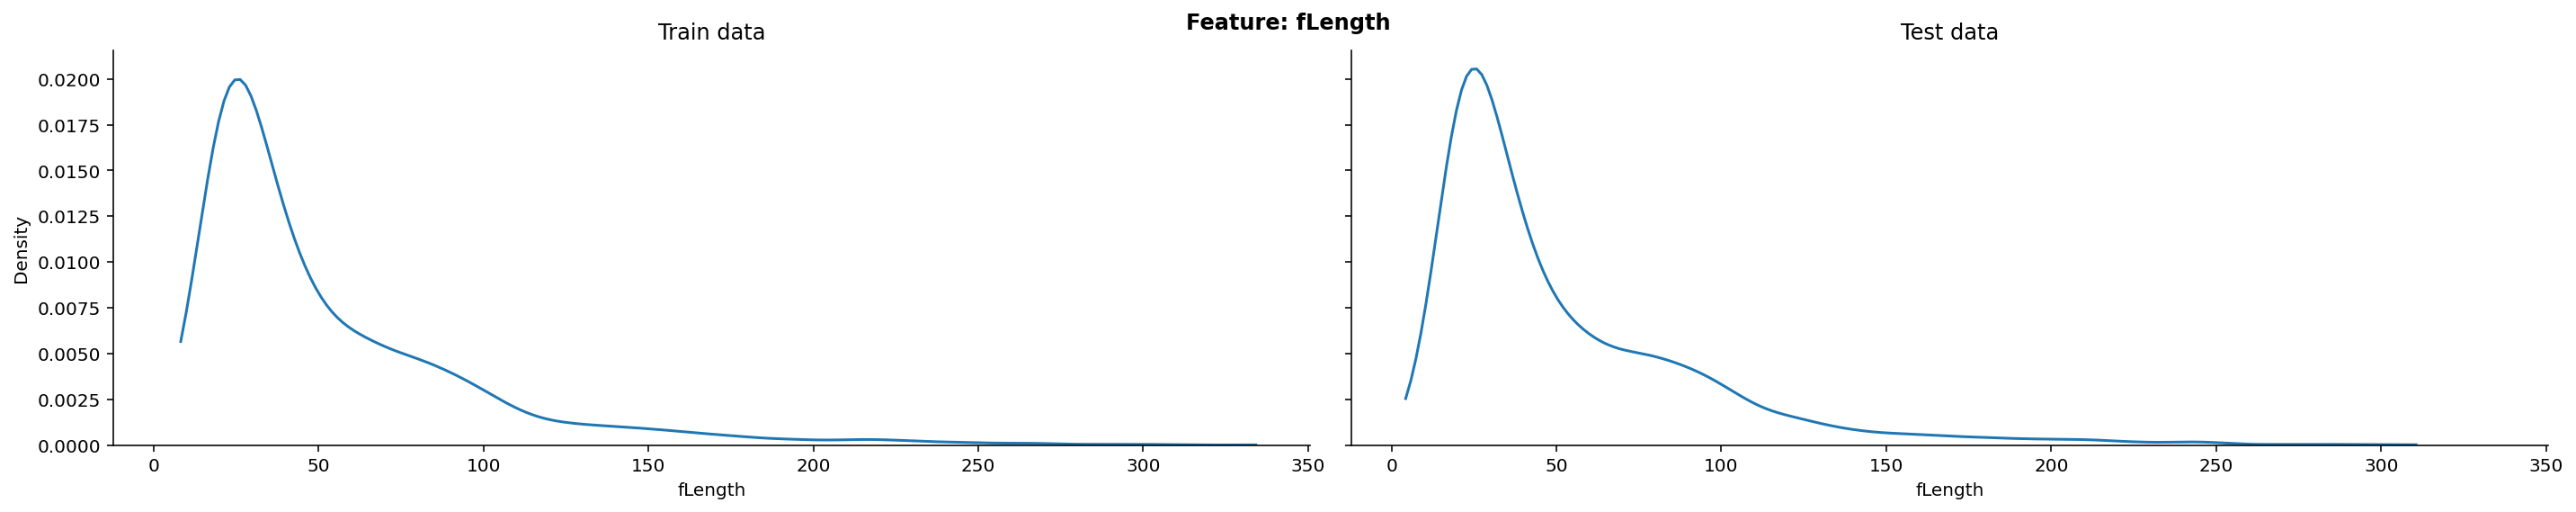

In [20]:
plot_cont('fLength')

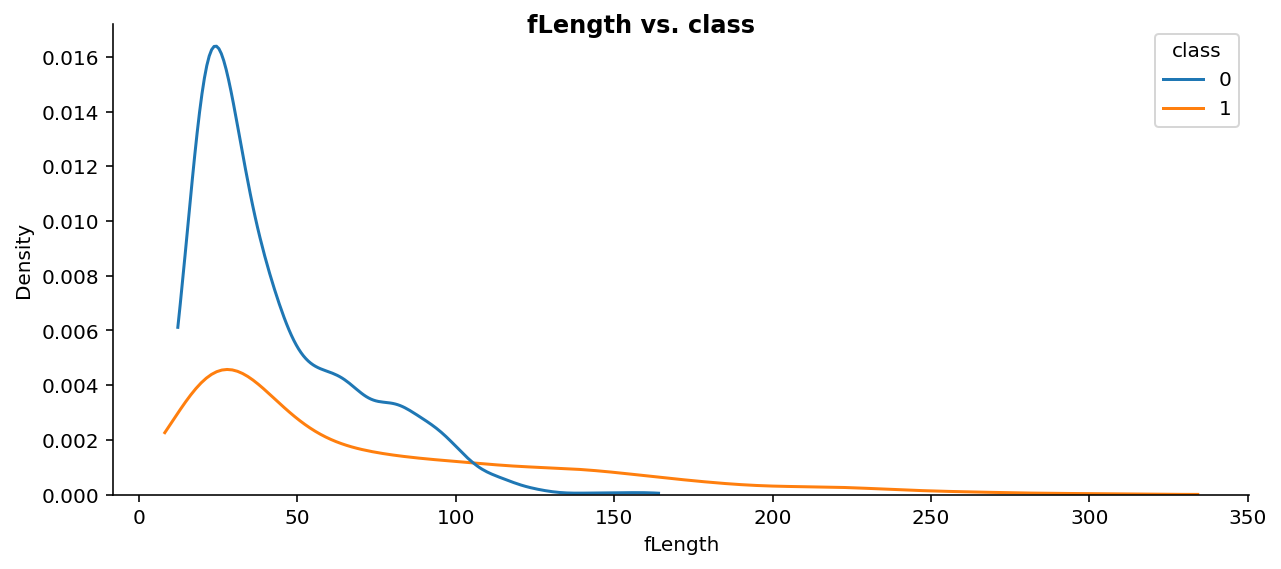

In [21]:
plot_cont_vs_target('fLength')

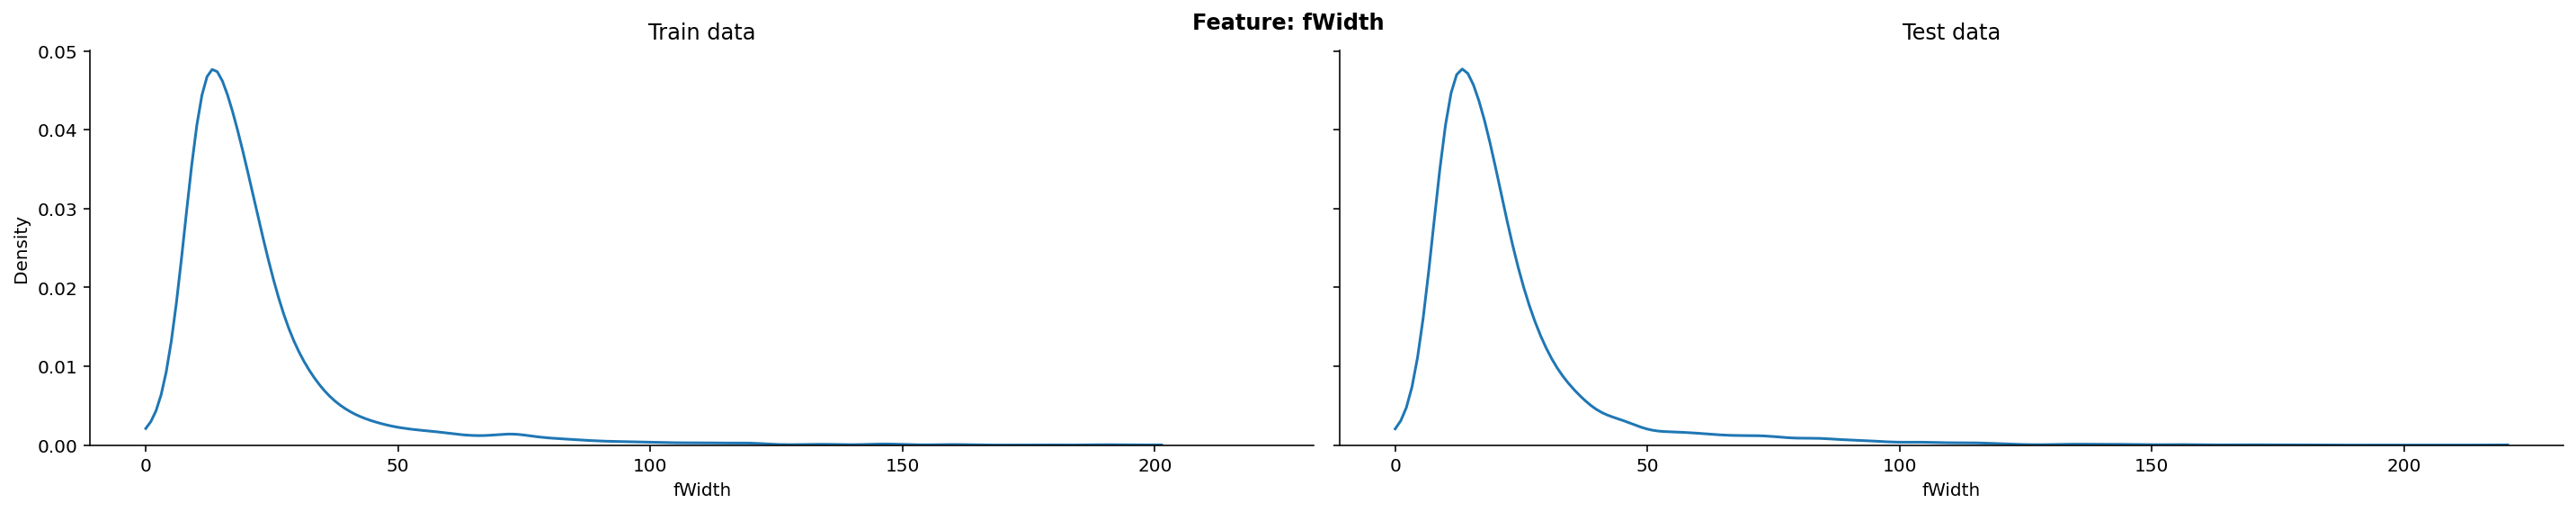

In [22]:
plot_cont('fWidth')

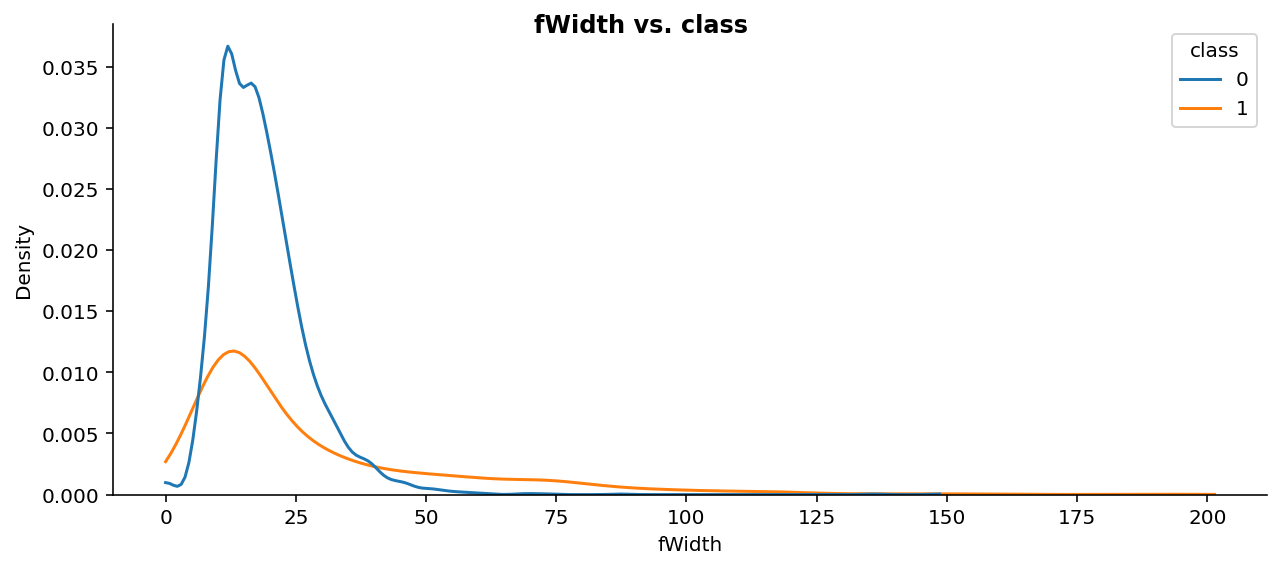

In [23]:
plot_cont_vs_target('fWidth')

In [24]:
train.groupby(TARGET)[['fLength', 'fWidth']].describe()

fLength                                                                  \
        count     mean      std      min      25%      50%       75%      max   
class                                                                           
0      3222.0  43.0933  25.7891  12.3403  23.3133  33.7493   58.1380  164.031   
1      1778.0  70.9379  58.8203   8.2304  26.1444  47.4831  103.3311  334.177   

       fWidth                                                             
        count     mean      std  min      25%      50%      75%      max  
class                                                                     
0      3222.0  18.5377   9.0584  0.0  12.1659  16.9698  22.5759  148.590  
1      1778.0  28.4274  26.8286  0.0  11.3331  17.1951  35.3432  201.364

### fSize

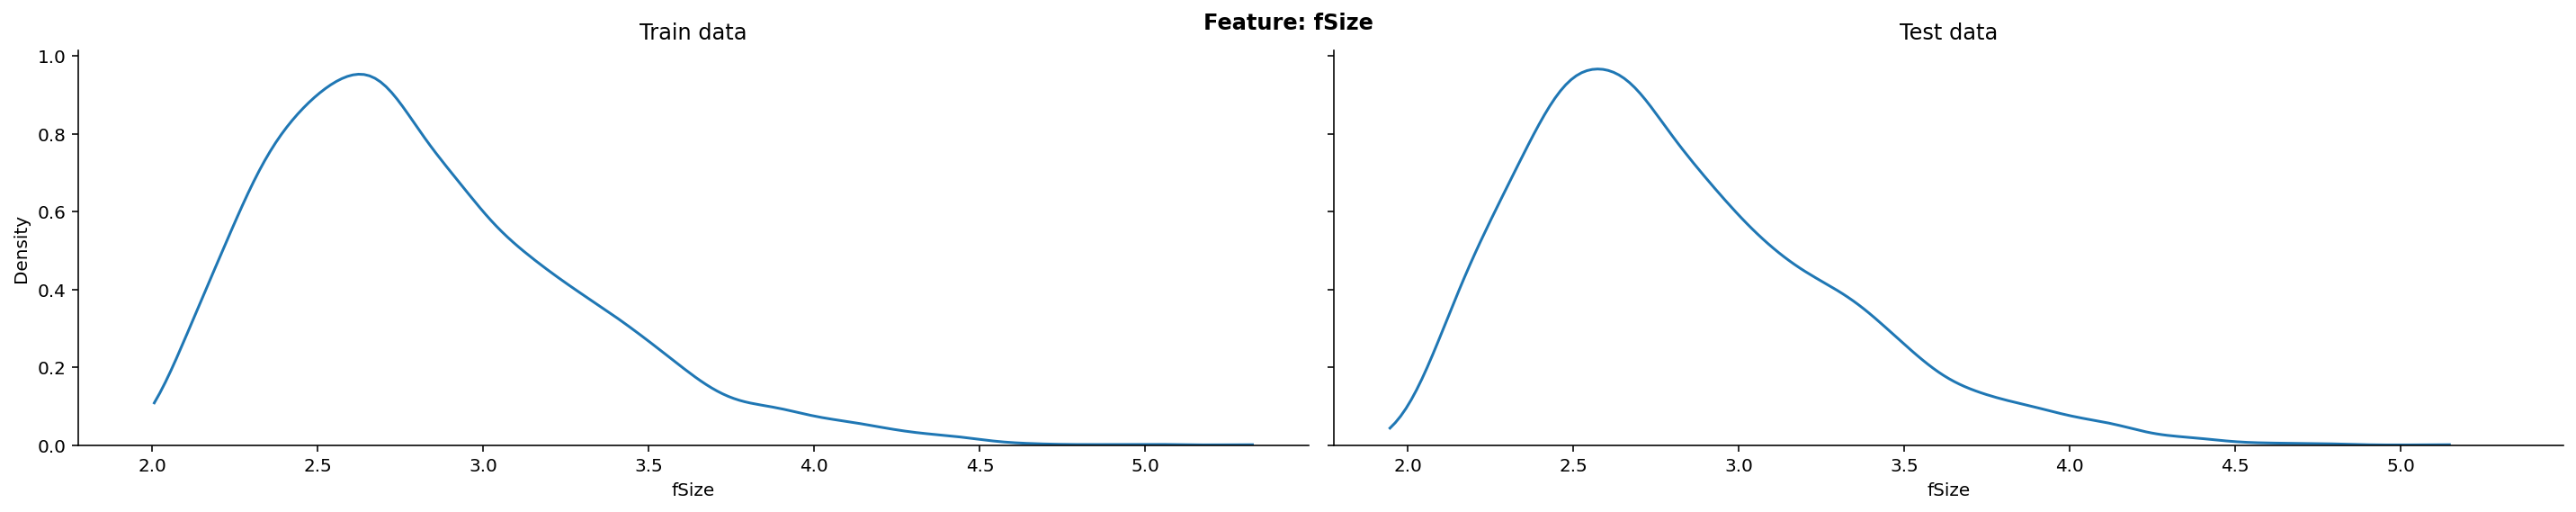

In [25]:
plot_cont('fSize')

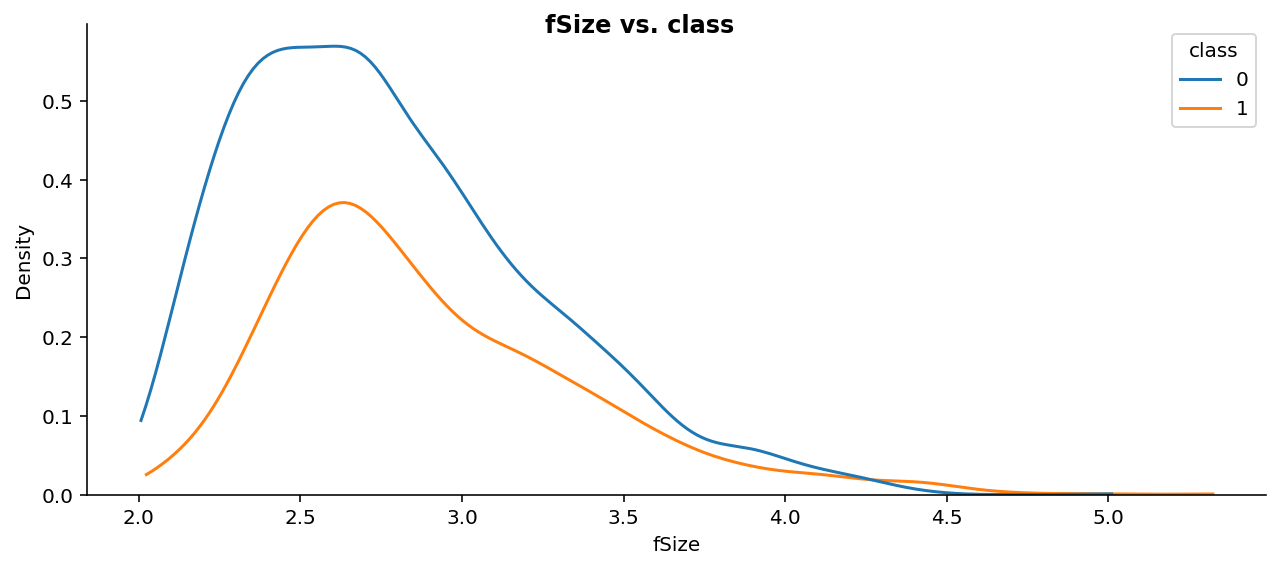

In [26]:
plot_cont_vs_target('fSize')

In [27]:
train.groupby(TARGET)['fSize'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,3222.0,2.778,0.4631,2.0065,2.4202,2.7005,3.0537,5.0100
1,1778.0,2.896,0.4821,2.0233,2.5547,2.7872,3.1687,5.3233


### fConc, fConc1

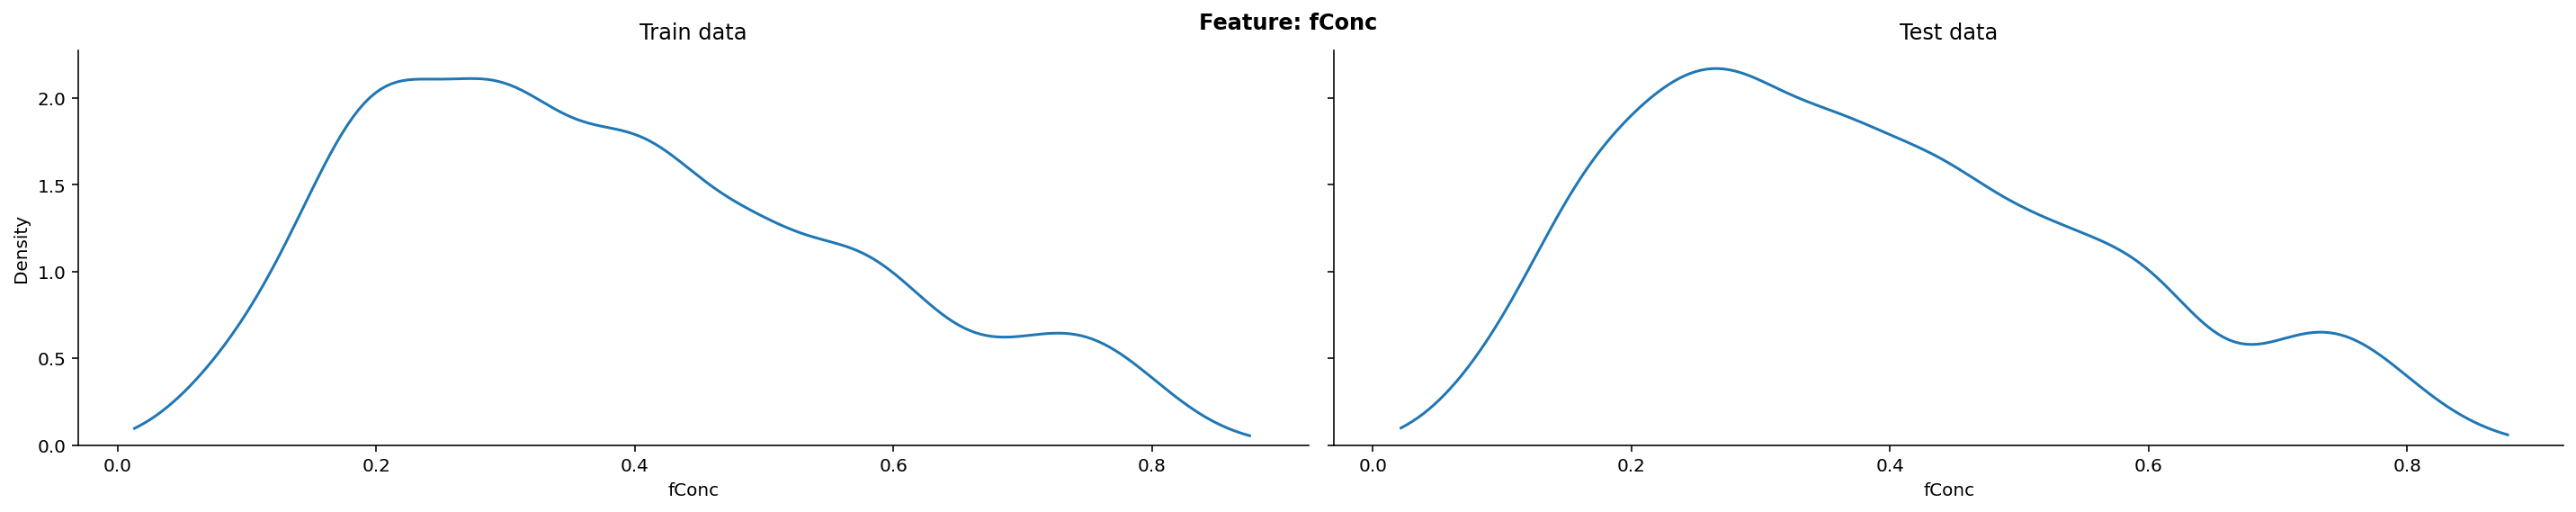

In [28]:
plot_cont('fConc')

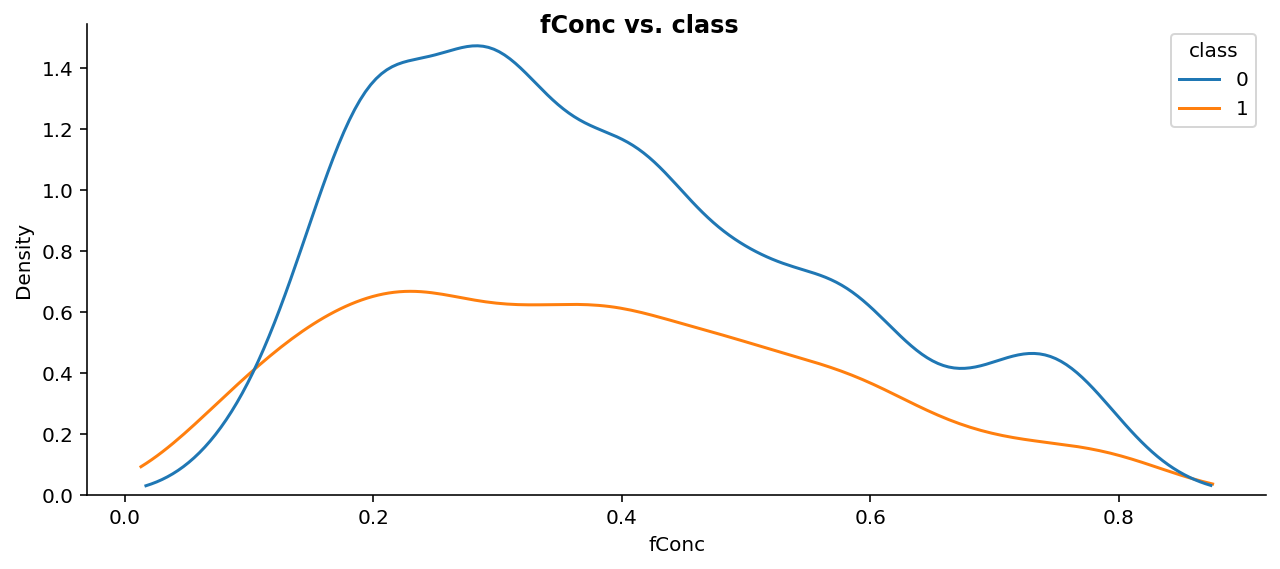

In [29]:
plot_cont_vs_target('fConc')

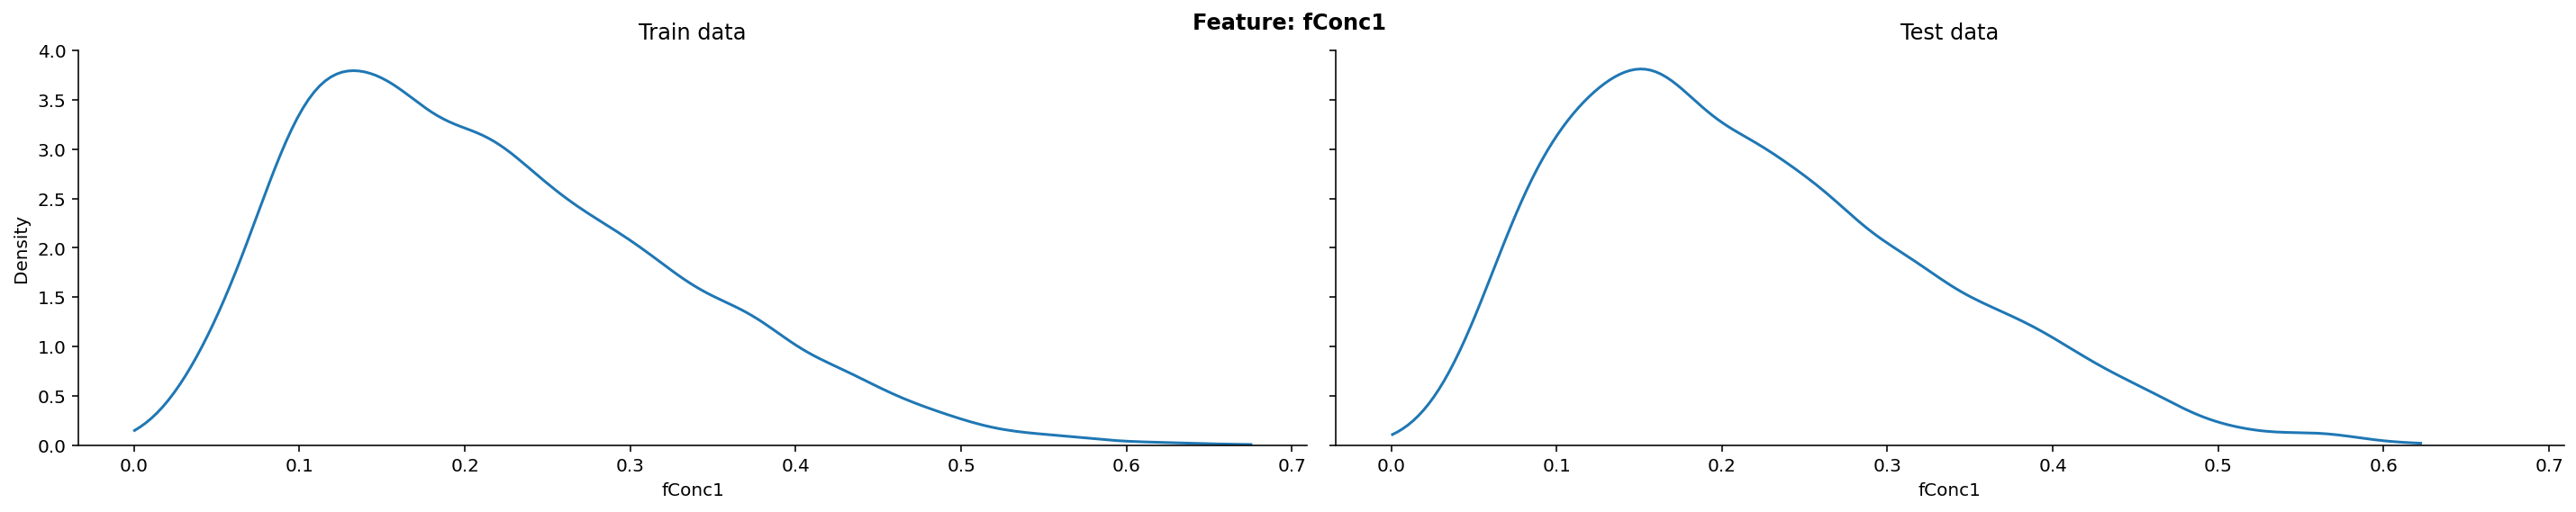

In [30]:
plot_cont('fConc1')

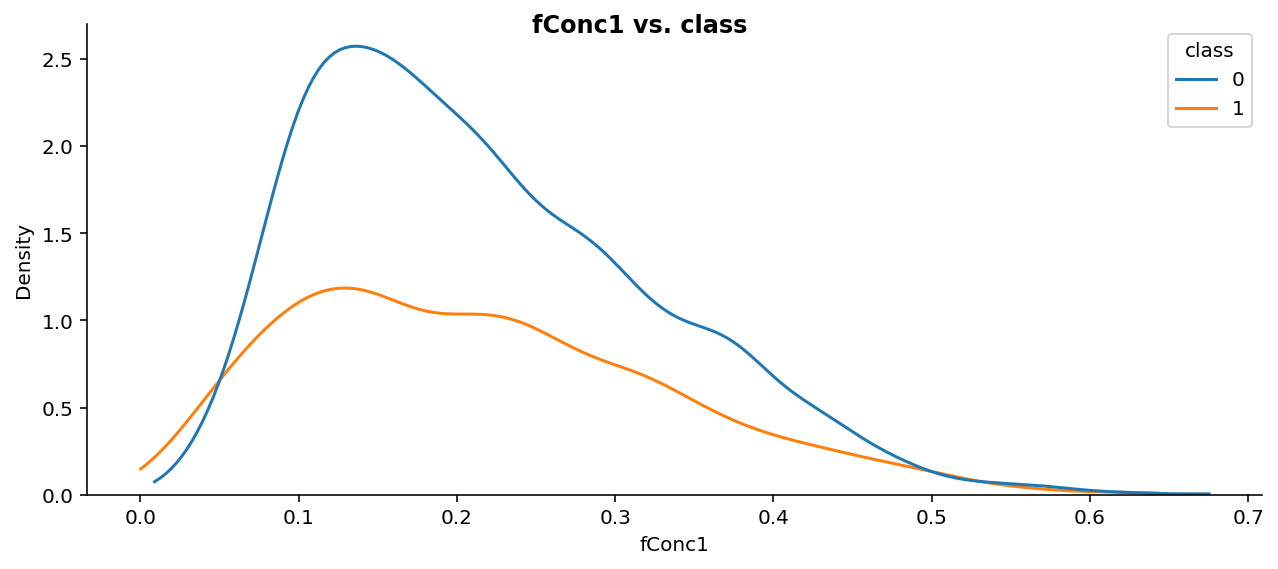

In [31]:
plot_cont_vs_target('fConc1')

In [32]:
train.groupby(TARGET)[['fConc', 'fConc1']].describe()

fConc                                                          fConc1  \
        count    mean     std     min     25%     50%     75%     max   count   
class                                                                           
0      3222.0  0.3864  0.1807  0.0171  0.2408  0.3553  0.5086  0.8743  3222.0   
1      1778.0  0.3734  0.1921  0.0131  0.2186  0.3561  0.5092  0.8757  1778.0   

                                                               
         mean     std     min     25%     50%     75%     max  
class                                                          
0      0.2166  0.1078  0.0090  0.1316  0.1963  0.2861  0.6752  
1      0.2141  0.1191  0.0003  0.1203  0.2006  0.2935  0.6430

### fAsym

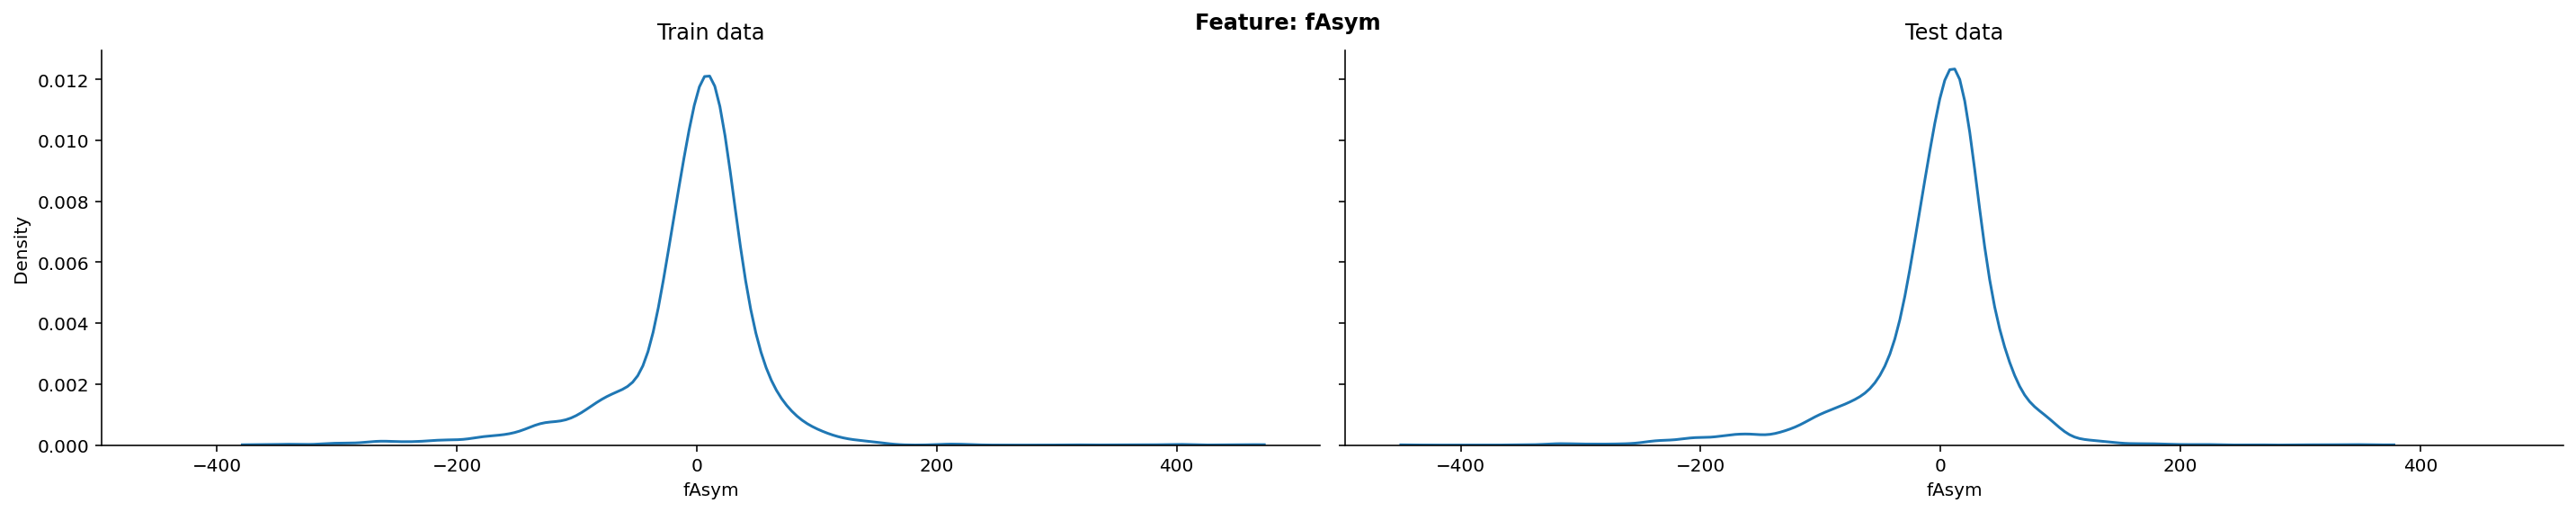

In [33]:
plot_cont('fAsym')

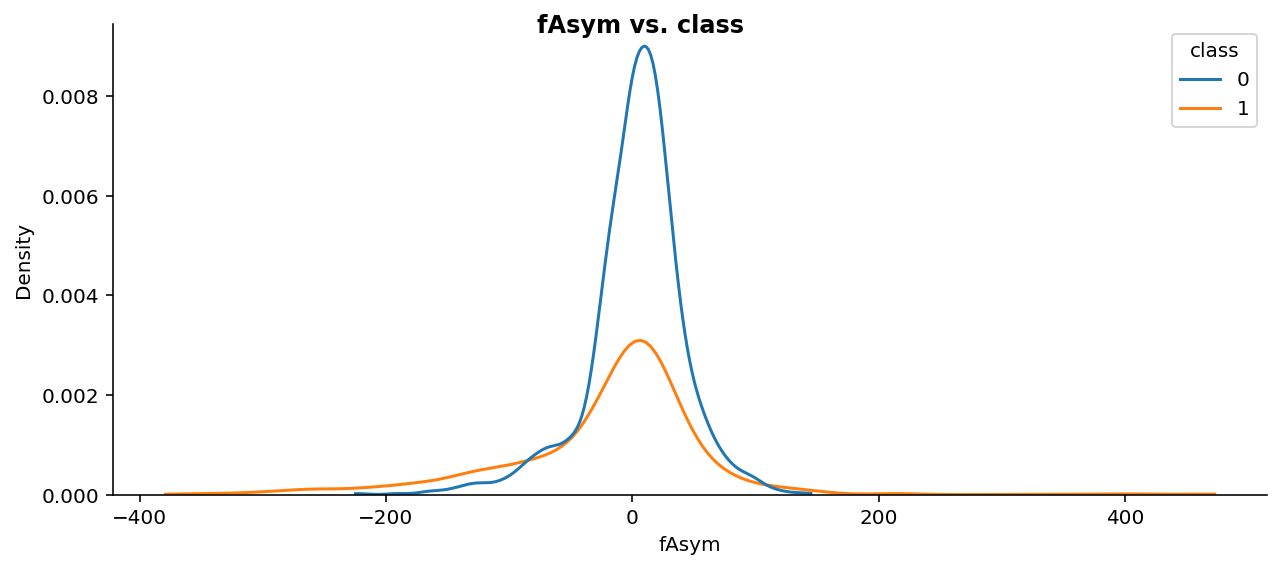

In [34]:
plot_cont_vs_target('fAsym')

In [35]:
train.groupby(TARGET)['fAsym'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,3222.0,3.1088,39.3794,-224.6450,-14.4730,6.2539,24.0551,145.0290
1,1778.0,-19.5023,82.0164,-378.9457,-46.0178,-2.5055,21.4405,473.0654


### fM3Long, fM3Trans

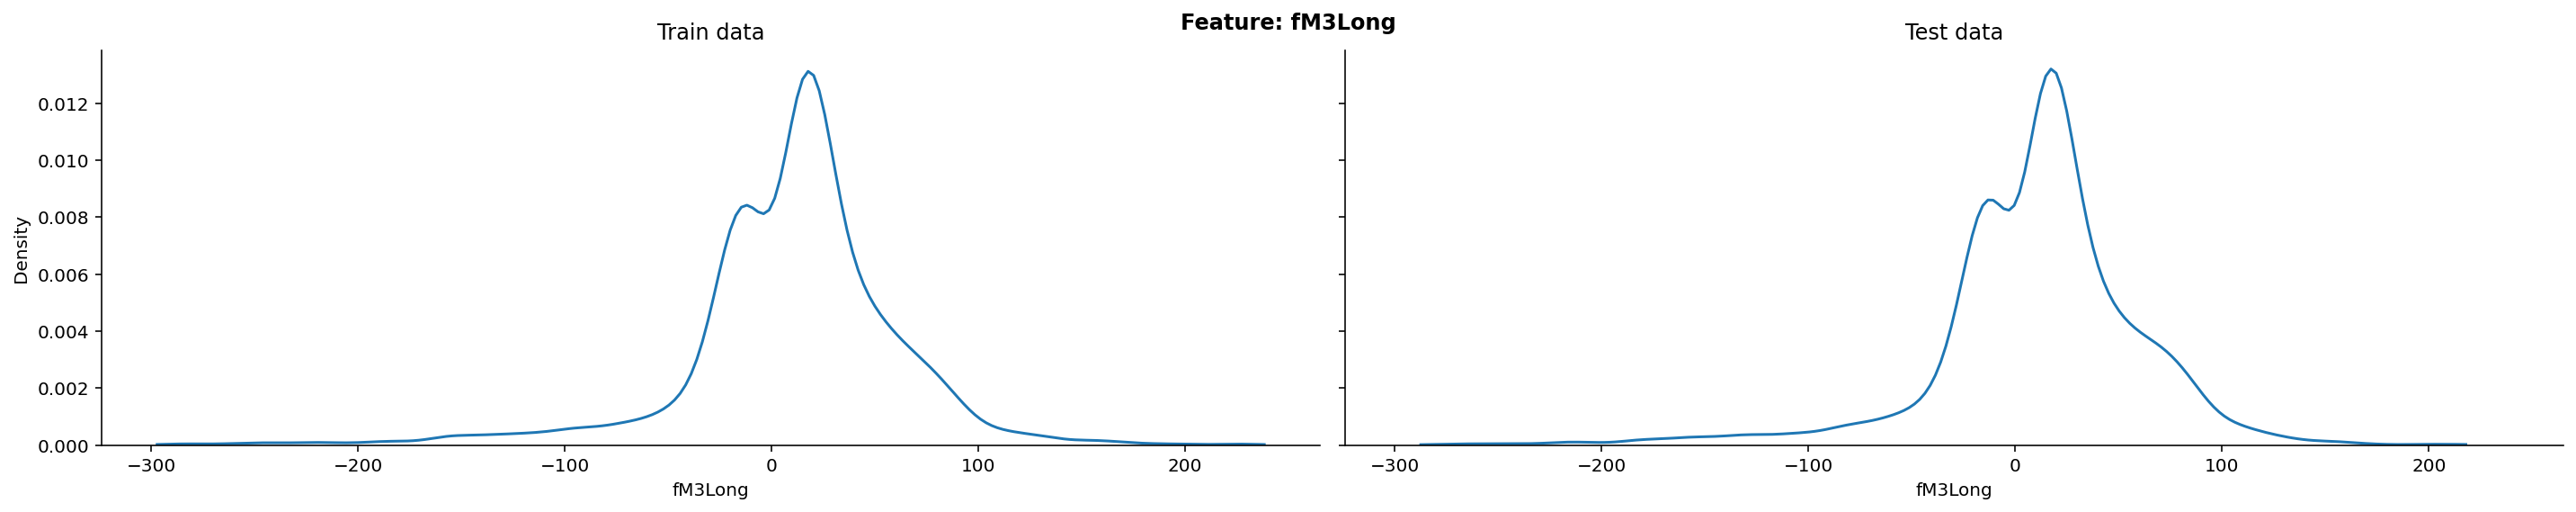

In [36]:
plot_cont('fM3Long')

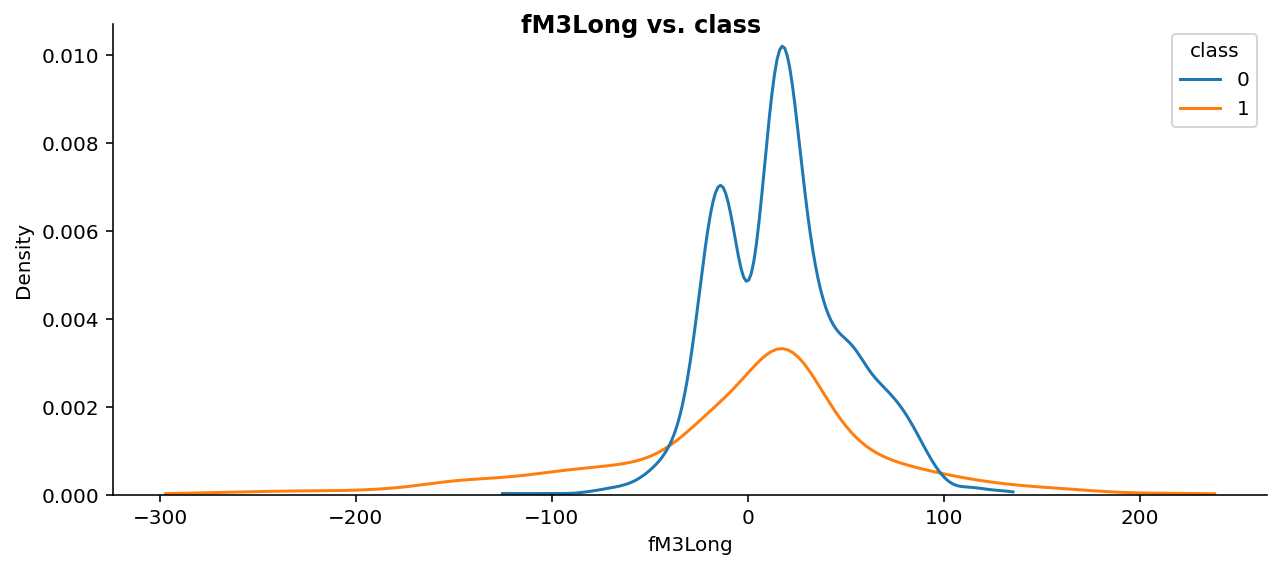

In [37]:
plot_cont_vs_target('fM3Long')

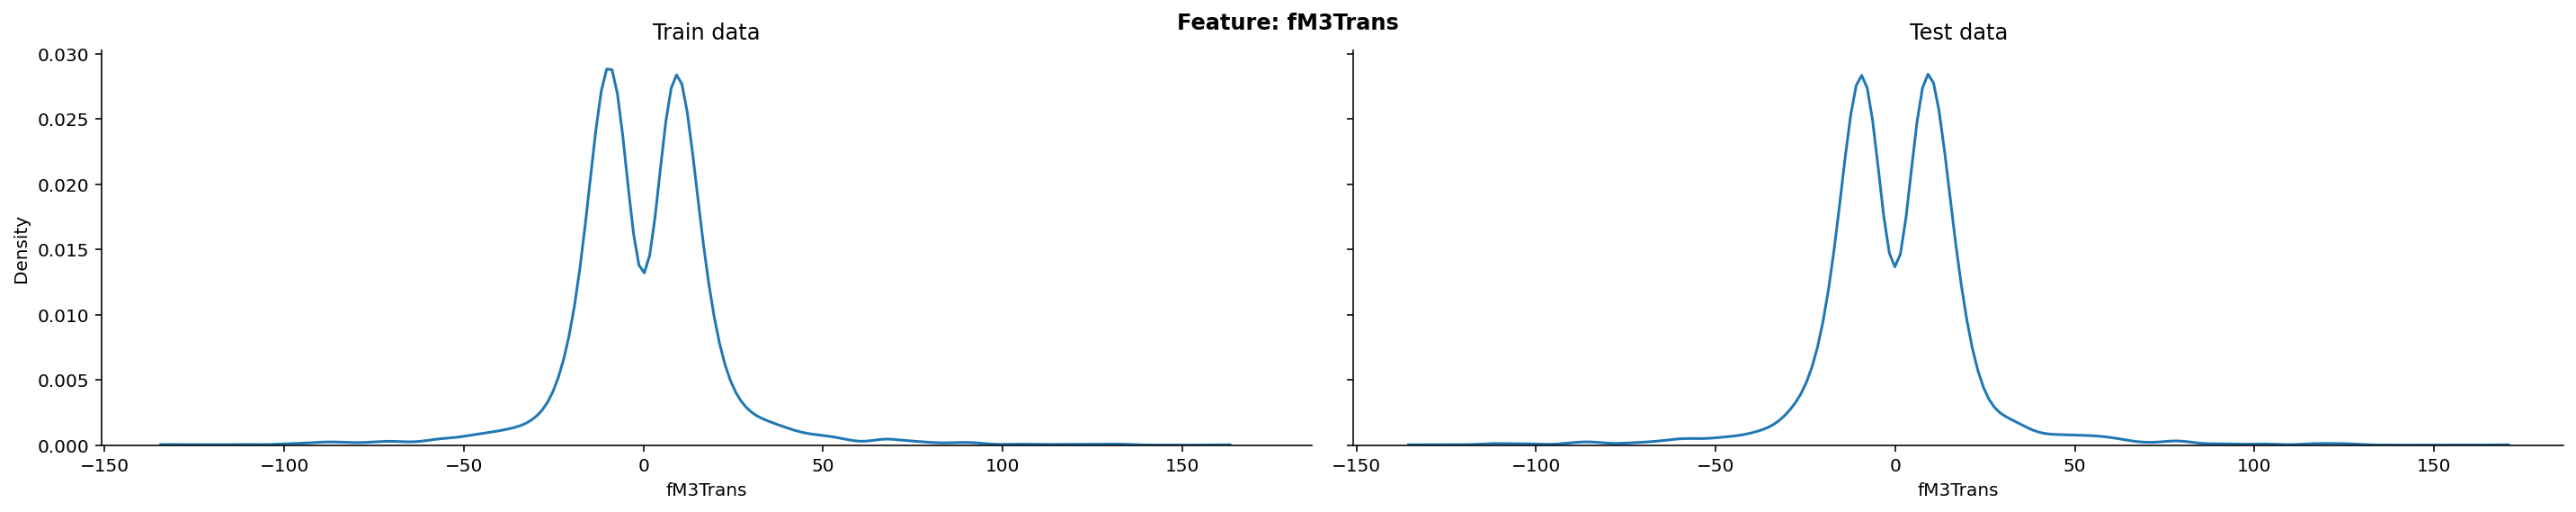

In [38]:
plot_cont('fM3Trans')

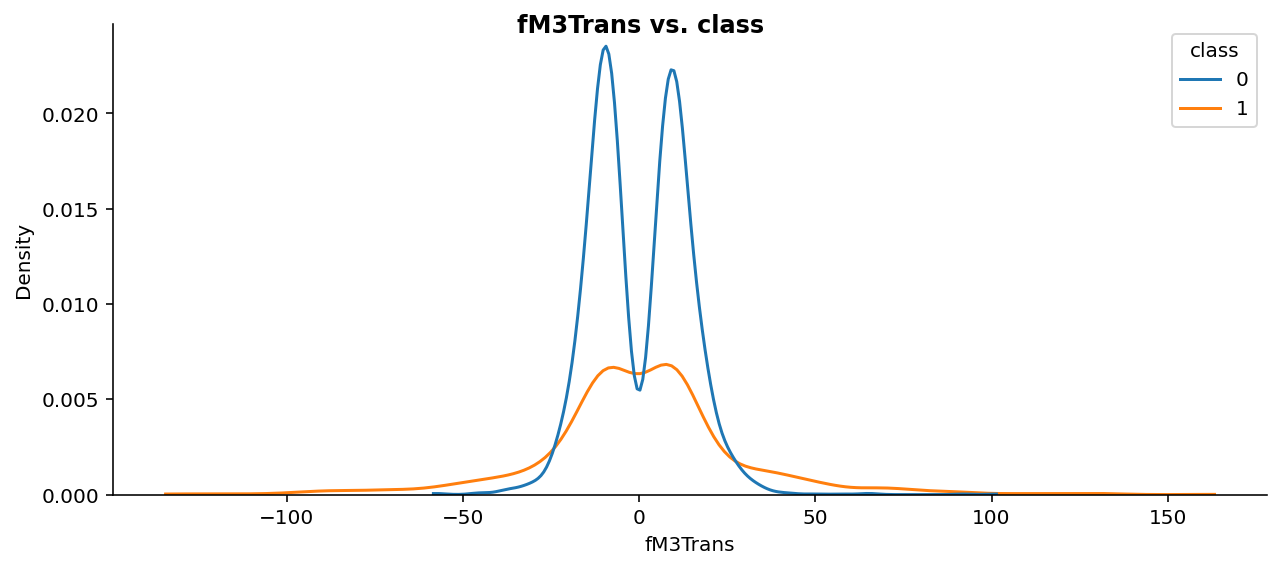

In [39]:
plot_cont_vs_target('fM3Trans')

In [40]:
train.groupby(TARGET)[['fM3Long', 'fM3Trans']].describe()

fM3Long                                                                  \
        count     mean      std       min      25%      50%      75%      max   
class                                                                           
0      3222.0  17.3473  33.0353 -125.2170  -8.9262  16.7296  36.0933  135.353   
1      1778.0  -2.2363  72.1622 -297.1717 -26.6088  12.2979  31.9216  238.321   

      fM3Trans                                                          \
         count    mean     std       min      25%         50%      75%   
class                                                                    
0       3222.0  0.1524  13.425  -58.3964 -10.5117 -5.0000e-05  10.4117   
1       1778.0  0.5790  29.187 -134.3950 -11.8084  7.3670e-01  11.9084   

                 
            max  
class            
0      101.3930  
1      163.2697

### fAlpha

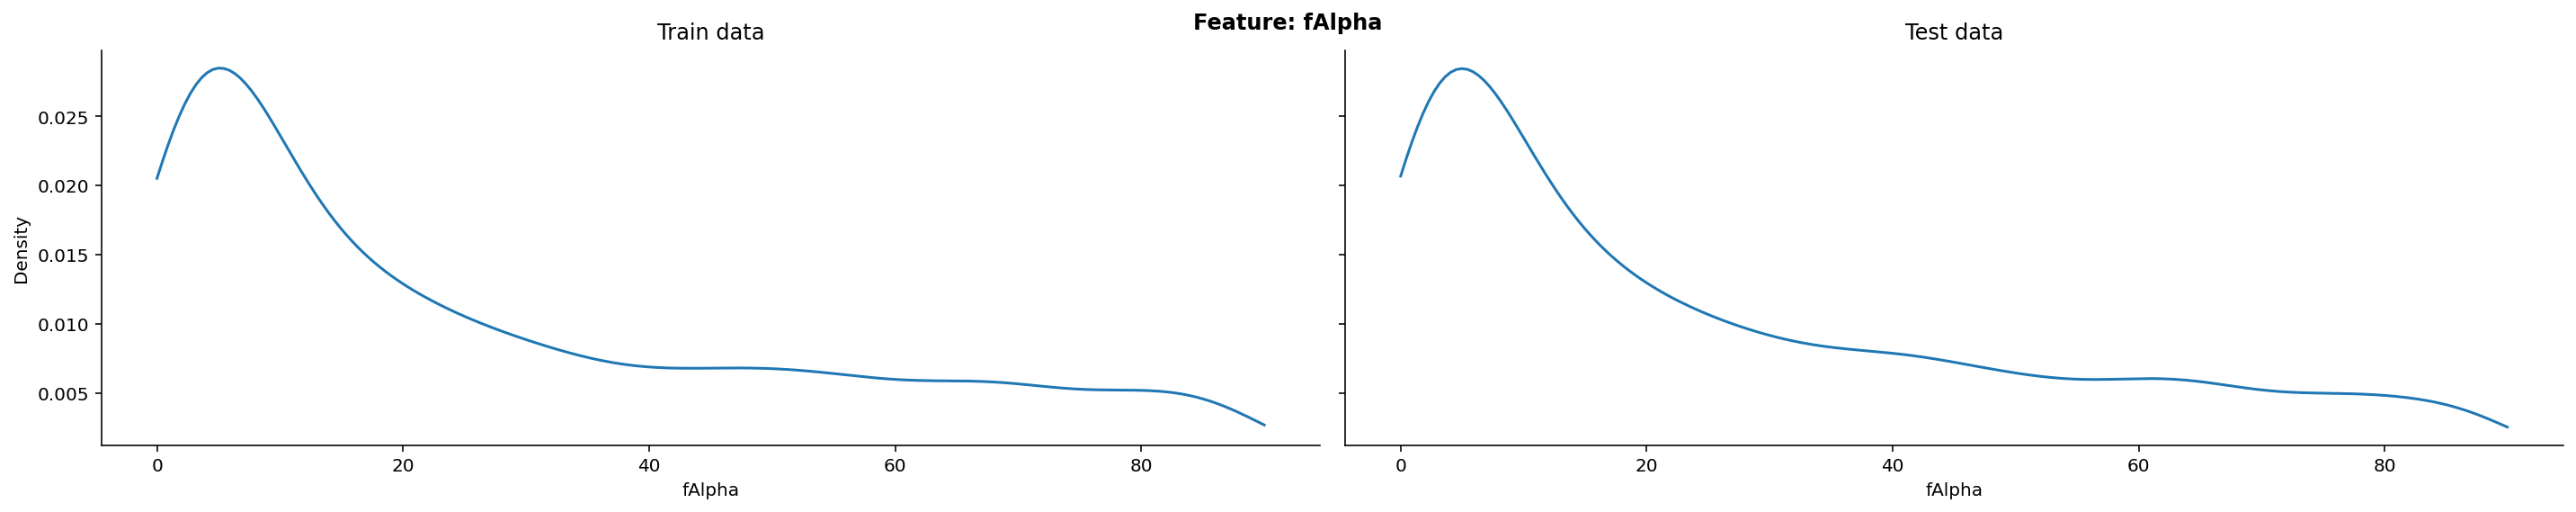

In [41]:
plot_cont('fAlpha')

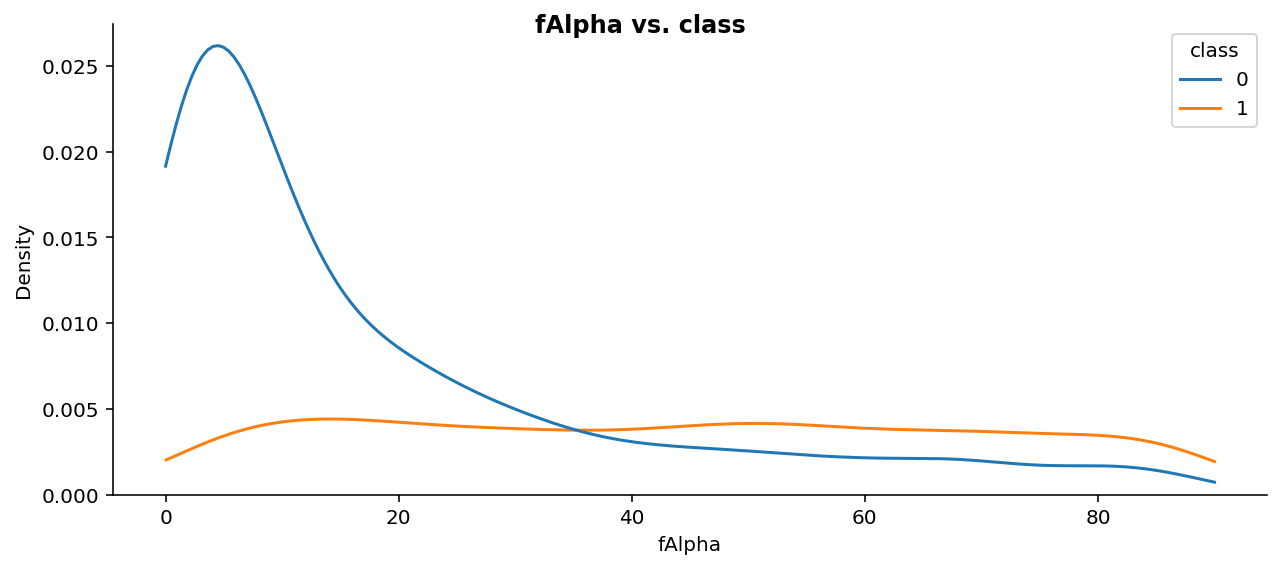

In [42]:
plot_cont_vs_target('fAlpha')

In [43]:
train.groupby(TARGET)['fAlpha'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,3222.0,19.0940,21.7744,0.0000,3.5877,9.6274,26.4599,90.0
1,1778.0,43.8335,26.0053,0.0502,20.5987,44.0328,66.5785,90.0


### fDist

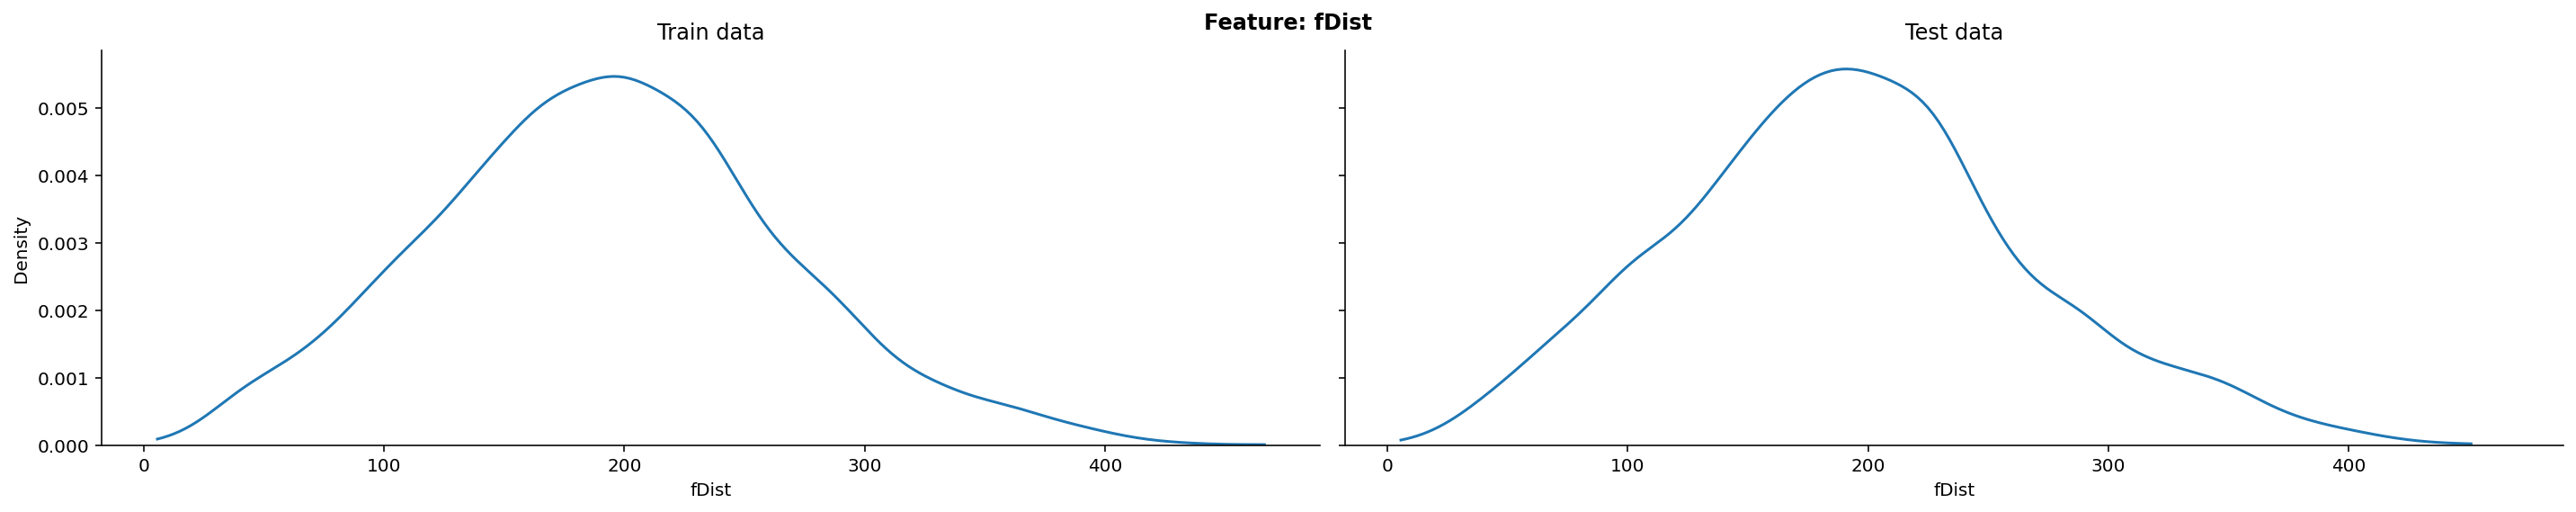

In [44]:
plot_cont('fDist')

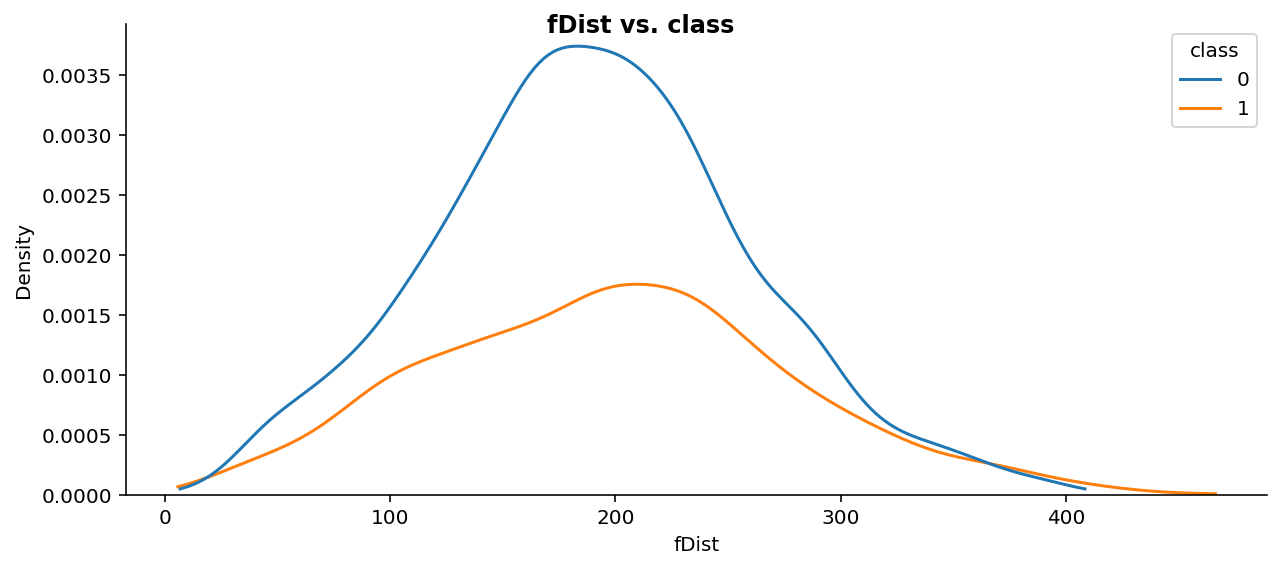

In [45]:
plot_cont_vs_target('fDist')

In [46]:
train.groupby(TARGET)['fDist'].describe()

,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
0,3222.0,189.9857,69.6113,6.6852,143.2877,188.236,233.9160,408.4530
1,1778.0,198.5888,80.0921,5.6998,140.8119,198.387,248.7476,466.4078


# Feature selection

In [47]:
features = list(test.columns)

### Pearson correlation

In [49]:
def plot_corr_matrix(corr_df, size=10):
    plt.figure(figsize=(size, size))
    sns.heatmap(corr_df,
                mask=np.triu(np.ones_like(corr_df)),
                vmin=-1, vmax=1, center=0, 
                annot=True, 
                linewidths=0.1)
    plt.show()

In [50]:
corr_df = train.corr()

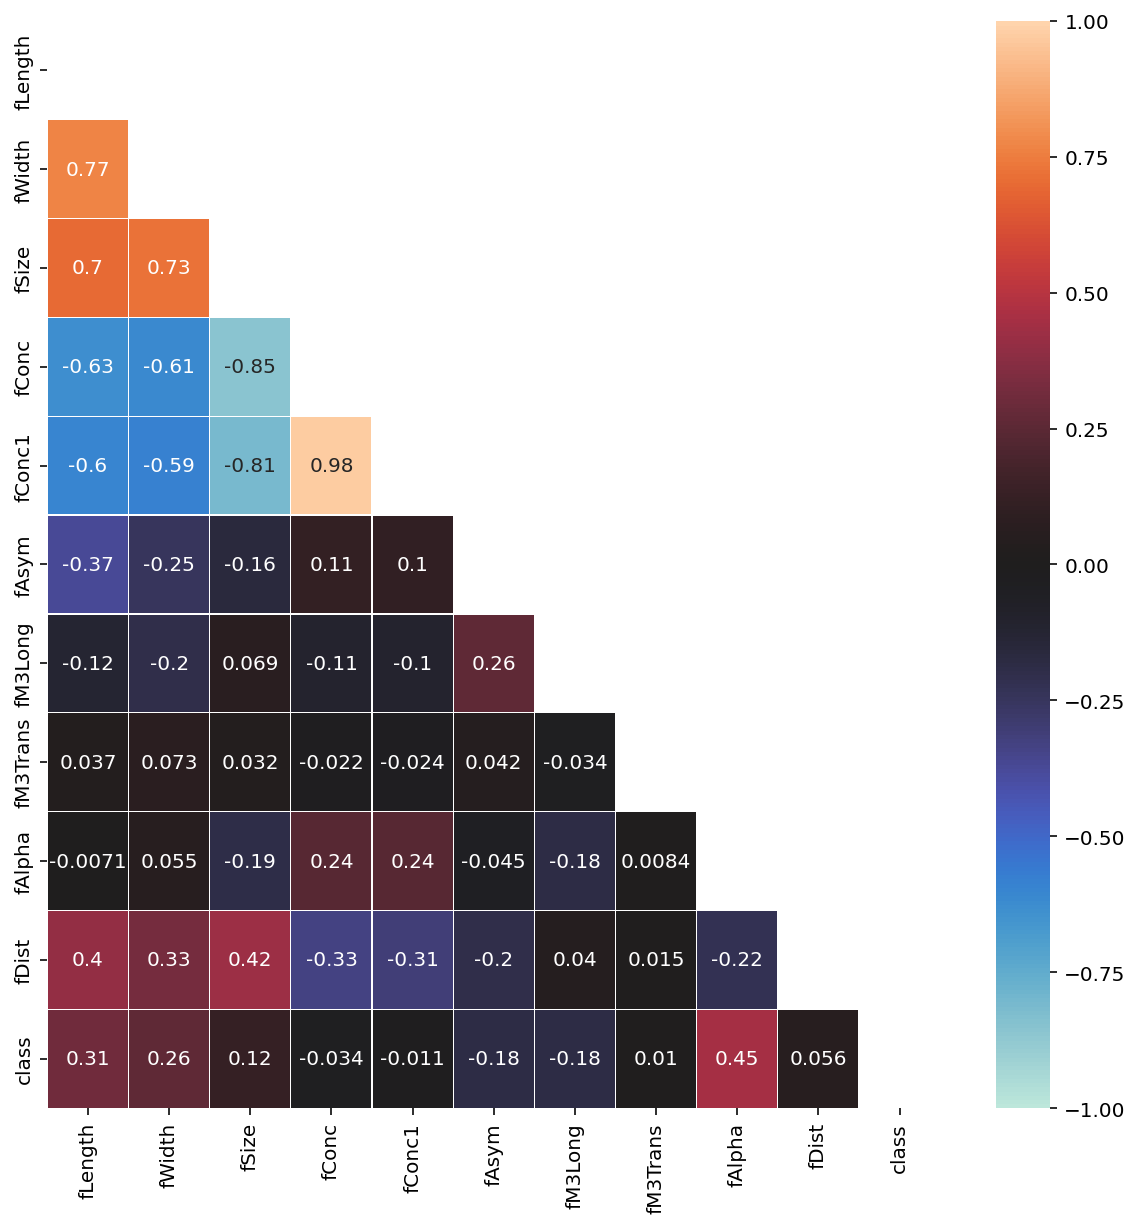

In [51]:
plot_corr_matrix(corr_df)

### ANOVA F-test

In [52]:
anova_test = f_classif(train[features], train[TARGET])

pd.DataFrame(
    data={
        'f-statistic': anova_test[0], 
        'p-value': anova_test[1],
        'accepted?': anova_test[1] < 0.05
    },
    index=features
)

,f-statistic,p-value,accepted?
fLength,535.5426,1.2176e-112,True
fWidth,362.9030,3.6497e-78,True
fSize,72.2480,2.4755e-17,True
fConc,5.6566,1.7427e-02,True
fConc1,0.5526,4.5730e-01,False
fAsym,172.7432,8.1487e-39,True
fM3Long,171.9973,1.1710e-38,True
fM3Trans,0.4975,4.8062e-01,False
fAlpha,1284.3268,1.5330e-250,True
fDist,15.6931,7.5532e-05,True


### Variance Inflation Factor

In [53]:
%%capture
!pip install --upgrade statsmodels==0.13.2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [54]:
def remove_vif_features(X: pd.DataFrame, threshold: float = 5.0) -> list:
    """Remove feature with highest Variance Inflation Factor
    at every iteration until all remaining features are below
    a certain threshold.
    """
    i = 0
    while True:
        vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        max_vif = np.max(vif)

        if max_vif <= threshold:
            break

        i += 1
        col_to_remove = X.columns[np.argmax(vif)]
        print(f"Iteration {i}: {col_to_remove:20} ({max_vif:.4f})")
        X.drop(col_to_remove, axis=1, inplace=True)

    if i == 0:
        print(f"No columns removed")
    else:
        print(pd.DataFrame({"Feature": X.columns, "VIF": vif}))

    return list(X.columns)

In [55]:
_ = remove_vif_features(train[features], 5) #rule-of-thumb threshold

Iteration 1: fConc                (111.6819)
Iteration 2: fSize                (21.0477)
Iteration 3: fLength              (7.5357)
Iteration 4: fDist                (6.2274)
    Feature     VIF
0    fWidth  1.6580
1    fConc1  2.2066
2     fAsym  1.1342
3   fM3Long  1.0937
4  fM3Trans  1.0097
5    fAlpha  2.4251


### Mutual Information score

In [56]:
mi_scores = mutual_info_classif(train[features], train[TARGET], random_state=SEED)

pd.DataFrame(
    data={'mi_score': mi_scores}, 
    index=features
).T

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
mi_score,0.0879,0.0916,0.0235,0.0139,0.0,0.0439,0.0825,0.0645,0.1138,0.0007


### Feature sets

In [57]:
#reduced based on correlation and ANOVA f-test
corr_features = [f for f in features if f not in ('fConc', 'fConc1', 'fM3Trans', 'fDist')]

#reduced based on variance inflation factor
vif_features = [f for f in features if f not in ('fConc1', 'fSize', 'fLength', 'fDist')]

#reduced based on mutual information score
mi_features = [f for f in features if f not in ('fConc1', 'fDist')]

# Baseline

In [64]:
def evaluate_model(feature_set):
    
    scores = []

    X, y = train[feature_set], train[TARGET]
    X_test = test[feature_set]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train, y_train = X.loc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.loc[val_idx], y.iloc[val_idx]

        model = RandomForestClassifier(
            n_estimators=150, 
            criterion='entropy', 
            max_depth=7,
            # class_weight='balanced',
            n_jobs=-1, 
            random_state=SEED
        )

        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)

        score = accuracy_score(y_val, val_preds)
        scores.append(score)
        print(f'Fold #{fold}: Accuracy = {score:.4f}')
        _ = gc.collect()

    print(f'\nAvg Accuracy = {np.mean(scores):.4f} +/- {np.std(scores):.4f}\n')

In [65]:
%%time
evaluate_model(features)

Fold #0: Accuracy = 0.8680
Fold #1: Accuracy = 0.8280
Fold #2: Accuracy = 0.8670
Fold #3: Accuracy = 0.8600
Fold #4: Accuracy = 0.8440

Avg Accuracy = 0.8534 +/- 0.0153

CPU times: user 10.4 s, sys: 174 ms, total: 10.6 s
Wall time: 6.54 s


In [66]:
%%time
evaluate_model(corr_features)

Fold #0: Accuracy = 0.8620
Fold #1: Accuracy = 0.8310
Fold #2: Accuracy = 0.8510
Fold #3: Accuracy = 0.8500
Fold #4: Accuracy = 0.8370

Avg Accuracy = 0.8462 +/- 0.0110

CPU times: user 7.61 s, sys: 228 ms, total: 7.84 s
Wall time: 5.14 s


In [67]:
%%time
evaluate_model(vif_features)

Fold #0: Accuracy = 0.8280
Fold #1: Accuracy = 0.7960
Fold #2: Accuracy = 0.8220
Fold #3: Accuracy = 0.8130
Fold #4: Accuracy = 0.8140

Avg Accuracy = 0.8146 +/- 0.0108

CPU times: user 7.73 s, sys: 215 ms, total: 7.94 s
Wall time: 5.14 s


In [68]:
%%time
evaluate_model(mi_features)

Fold #0: Accuracy = 0.8670
Fold #1: Accuracy = 0.8220
Fold #2: Accuracy = 0.8520
Fold #3: Accuracy = 0.8490
Fold #4: Accuracy = 0.8320

Avg Accuracy = 0.8444 +/- 0.0158

CPU times: user 7.61 s, sys: 191 ms, total: 7.8 s
Wall time: 5.13 s
